In [1]:
# Install dependencies (for Google Colab or first-time use)
!pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

# Imports

In [2]:
# Imports
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
import os
from docx import Document
import unicodedata

In [3]:
# === Load BioBERT model and tokenizer ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

C:\Users\Lenovo\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [4]:
# === Define UNet model for USG image feature extraction ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(UNetModel, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

In [5]:
# === Define Multimodal Feature Fusion (M2Gen) ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super(M2Gen, self).__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)

    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

In [6]:
# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)


In [7]:
# === Helper Functions ===

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(image_tensor)
    pooled = torch.mean(features, dim=[2, 3])
    return pooled

def read_clinical_report(docx_path):
    doc = Document(docx_path)
    full_text = '\n'.join([para.text for para in doc.paragraphs])
    return full_text.strip()

def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def generate_report(image_paths, report_text):
    text_features = encode_text(report_text).to(device)
    combined_scores = []
    explanations = []

    for path in image_paths:
        image_features = process_usg_image(path)
        score = fusion_model(image_features, text_features).item()
        combined_scores.append(score)
        status = "Abnormality detected" if score > 0.5 else "No abnormality detected"
        explanations.append(f"Image: {os.path.basename(path)} -> AI Risk Score: {score:.2f} -> {status}")

    avg_score = sum(combined_scores) / len(combined_scores)
    summary = "AI Summary: The ultrasound images indicate potential abnormal findings." if avg_score > 0.5 else "AI Summary: No significant abnormalities detected in the provided ultrasound images."
    return avg_score, explanations, summary

def create_pdf(report_text, image_paths, report_score, explanations, summary, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, "Automated Radiological Report", ln=True, align="C")
    pdf.ln(10)
    pdf.multi_cell(0, 10, "Clinical Summary:\n" + clean_text(report_text))
    pdf.ln(5)
    pdf.multi_cell(0, 10, clean_text(summary))
    pdf.ln(10)
    pdf.cell(200, 10, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for explanation in explanations:
        pdf.multi_cell(0, 10, clean_text(explanation))

    for path in image_paths:
        pdf.add_page()
        pdf.cell(200, 10, f"Ultrasound Image: {os.path.basename(path)}", ln=True)
        try:
            pdf.image(path, x=10, y=30, w=180)
        except Exception as e:
            pdf.multi_cell(0, 10, f"Image could not be displayed. Error: {str(e)}")

    pdf.output(output_path)
    return output_path


In [8]:
# === 🔽 USER INPUT: UPDATE THESE PATHS ===
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
docx_report_path = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Reports\USG-OBG Ayesha Shivmogga.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

In [9]:
# === 🧾 RUN PIPELINE ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    report_text = read_clinical_report(docx_report_path)
    score, explanations, summary = generate_report(image_paths, report_text)
    try:
        result_path = create_pdf(report_text, image_paths, score, explanations, summary, output_pdf_path)
        print("✅ PDF saved at:", result_path)
    except PermissionError:
        print("❌ Error: PDF file may be open. Please close it and try again.")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Lenovo\\Downloads\\Scna reports and Images\\Scna reports and Images\\Images\\11022025-51_AYESHA SHIMOGA'

In [15]:
!pip install transformers torch torchvision monai fpdf opencv-python

In [16]:
# === Define UNet model for USG image feature extraction ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(UNetModel, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

In [17]:
# 2. Simple Description Generator (Mocked)


def generate_brief_description(score):
    if score < 0.3:
        return "No abnormality detected."
    elif score < 0.6:
        return "Minor echogenic irregularity noticed."
    elif score < 0.8:
        return "Suspicious region detected for review."
    else:
        return "Significant abnormality detected. Further investigation recommended."


In [18]:
# 3. Image Scoring Model (Mock M2Gen)


class M2Gen(nn.Module):
    def __init__(self, image_features_dim):
        super(M2Gen, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_features_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Risk score 0–1
        )

    def forward(self, image_features):
        return self.fc(image_features)

In [19]:
# 4. Image Processing


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
score_model = M2Gen(image_features_dim=64).to(device)

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    pooled = torch.mean(features, dim=[2, 3])  # Global Average Pooling
    return pooled

In [20]:
# 5. Generate Report Content


def generate_report(image_paths):
    scores = []
    explanations = []
    
    for path in image_paths:
        features = process_usg_image(path)
        score = score_model(features).item()
        scores.append(score)
        desc = generate_brief_description(score)
        explanations.append(f"Image: {os.path.basename(path)} -> AI Risk Score: {score:.2f}\nFinding: {desc}")
    
    avg_score = sum(scores) / len(scores) if scores else 0
    return avg_score, explanations

In [21]:
# 6. PDF Generation
# ========================

def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def create_pdf(image_paths, report_score, explanations, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, "Automated Radiological Report", ln=True, align="C")
    pdf.ln(10)
    pdf.cell(200, 10, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for explanation in explanations:
        pdf.multi_cell(0, 10, clean_text(explanation))
        pdf.ln(2)

    for path in image_paths:
        pdf.add_page()
        pdf.cell(200, 10, f"Ultrasound Image: {os.path.basename(path)}", ln=True)
        try:
            pdf.image(path, x=10, y=30, w=180)
        except:
            pdf.multi_cell(0, 10, "Image preview could not be loaded.")

    pdf.output(output_path)
    return output_path


In [22]:
# 7. RUN PIPELINE
# ========================

# 🔽 USER INPUT SECTION
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

if __name__ == "__main__":
    image_paths = [
        os.path.join(image_folder, f)
        for f in os.listdir(image_folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]

    score, explanations = generate_report(image_paths)
    result_path = create_pdf(image_paths, score, explanations, output_pdf_path)
    print("✅ PDF saved at:", result_path)

✅ PDF saved at: C:\Users\Lenovo\Desktop\radiological_report.pdf


In [23]:
!pip install transformers torch torchvision monai fpdf opencv-python


In [24]:
import os
import torch
import torch.nn as nn
import cv2
from torchvision import transforms
from monai.networks.nets import UNet
from fpdf import FPDF
import unicodedata


In [25]:
# 1. M2Gen Risk Scoring Model
class M2Gen(nn.Module):
    def __init__(self, image_features_dim):
        super(M2Gen, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_features_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output score between 0–1
        )

    def forward(self, image_features):
        return self.fc(image_features)

In [26]:
# 2. UNet Model
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(UNetModel, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

In [27]:
# 3. Explanation based on score
def generate_brief_description(score):
    if score < 0.3:
        return "No abnormality detected."
    elif score < 0.6:
        return "Minor echogenic irregularity noticed."
    elif score < 0.8:
        return "Suspicious region detected for review."
    else:
        return "Significant abnormality detected. Further investigation recommended."

In [28]:
# 4. AI Image Scoring
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
score_model = M2Gen(image_features_dim=64).to(device)

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    pooled = torch.mean(features, dim=[2, 3])  # Global Average Pooling
    return pooled

In [29]:
# 5. Generate text findings
def generate_report(image_paths):
    scores = []
    explanations = []
    
    for path in image_paths:
        features = process_usg_image(path)
        score = score_model(features).item()
        scores.append(score)
        desc = generate_brief_description(score)
        explanations.append(f"Image: {os.path.basename(path)}\nAI Risk Score: {score:.2f}\nFinding: {desc}")
    
    avg_score = sum(scores) / len(scores) if scores else 0
    return avg_score, explanations

In [30]:
# 6. PDF Report Formatter
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def create_pdf(image_paths, report_score, findings, output_path, patient_name, age, ref_by, date_str):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=11)

    pdf.cell(200, 10, "Dr.Ghanti’s Foundation for Digestive Diseases and Endoscopy Centre", ln=True, align='C')
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 10, "Radiology Department - Obstetric Ultrasound Report", ln=True, align='C')
    pdf.ln(5)

    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, f"Patient Name: {patient_name}     Age/Sex: {age}\nRef By: {ref_by}     Date: {date_str}")
    pdf.ln(3)

    pdf.set_font("Arial", 'B', 11)
    pdf.cell(200, 10, "AI-Guided Radiology Findings:", ln=True)
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 8, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for text in findings:
        pdf.multi_cell(0, 8, clean_text(text))
        pdf.ln(2)

    # Add each image with caption
    for path in image_paths:
        pdf.add_page()
        pdf.set_font("Arial", 'B', 11)
        pdf.cell(200, 10, f"Image: {os.path.basename(path)}", ln=True)
        try:
            pdf.image(path, x=15, y=30, w=180)
        except:
            pdf.set_font("Arial", 'I', 10)
            pdf.cell(200, 10, "Image preview not available", ln=True)


In [31]:
# Final disclaimer
    pdf.add_page()
    pdf.set_font("Arial", 'I', 9)
    pdf.multi_cell(0, 6, 
        "This report is AI-assisted and is not a substitute for clinical evaluation.\n"
        "Declaration: AI has not detected or disclosed the fetal sex.\n"
        "All congenital anomalies may not be detectable due to fetal position, gestational age, etc.\n"
        "This report adheres to PNDT guidelines. For diagnostic use only."
    )

    pdf.output(output_path)
    return output_path

IndentationError: unexpected indent (1641904187.py, line 2)

In [32]:
def create_pdf(image_paths, report_score, findings, output_path, patient_name, age, ref_by, date_str):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=11)

    pdf.cell(200, 10, "Dr.Ghanti’s Foundation for Digestive Diseases and Endoscopy Centre", ln=True, align='C')
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 10, "Radiology Department - Obstetric Ultrasound Report", ln=True, align='C')
    pdf.ln(5)

    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, f"Patient Name: {patient_name}     Age/Sex: {age}\nRef By: {ref_by}     Date: {date_str}")
    pdf.ln(3)

    pdf.set_font("Arial", 'B', 11)
    pdf.cell(200, 10, "AI-Guided Radiology Findings:", ln=True)
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 8, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for text in findings:
        pdf.multi_cell(0, 8, clean_text(text))
        pdf.ln(2)

    for path in image_paths:
        pdf.add_page()
        pdf.set_font("Arial", 'B', 11)
        pdf.cell(200, 10, f"Image: {os.path.basename(path)}", ln=True)
        try:
            pdf.image(path, x=15, y=30, w=180)
        except:
            pdf.set_font("Arial", 'I', 10)
            pdf.cell(200, 10, "Image preview not available", ln=True)

    pdf.add_page()
    pdf.set_font("Arial", 'I', 9)
    pdf.multi_cell(0, 6, 
        "This report is AI-assisted and is not a substitute for clinical evaluation.\n"
        "Declaration: AI has not detected or disclosed the fetal sex.\n"
        "All congenital anomalies may not be detectable due to fetal position, gestational age, etc.\n"
        "This report adheres to PNDT guidelines. For diagnostic use only."
    )

    pdf.output(output_path)
    return output_path


In [34]:
# Minimal call after setup
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

score, findings = generate_report(image_paths)
output_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

# Metadata
patient_name = "Ayesha Shivmogga"
age = "29/F"
ref_by = "Dr. Noorjahan"
date_str = "2025-02-11"

# PDF Generation
result_path = create_pdf(image_paths, score, findings, output_path, patient_name, age, ref_by, date_str)
print("✅ Report saved to:", result_path)


UnicodeEncodeError: 'latin-1' codec can't encode character '\u2019' in position 60: ordinal not in range(256)

In [35]:
!pip install transformers torch torchvision monai fpdf opencv-python


In [36]:
import os
import torch
import torch.nn as nn
import cv2
from torchvision import transforms
from monai.networks.nets import UNet
from fpdf import FPDF
import unicodedata

In [37]:
# 1. M2Gen Risk Scoring Model
class M2Gen(nn.Module):
    def __init__(self, image_features_dim):
        super(M2Gen, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_features_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output score between 0–1
        )

    def forward(self, image_features):
        return self.fc(image_features)

In [38]:
# 2. UNet Model
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(UNetModel, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

In [39]:
# 3. Explanation based on score
def generate_brief_description(score):
    if score < 0.3:
        return "No abnormality detected."
    elif score < 0.6:
        return "Minor echogenic irregularity noticed."
    elif score < 0.8:
        return "Suspicious region detected for review."
    else:
        return "Significant abnormality detected. Further investigation recommended."

In [41]:
# 4. AI Image Scoring
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
score_model = M2Gen(image_features_dim=64).to(device)

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    pooled = torch.mean(features, dim=[2, 3])  # Global Average Pooling
    return pooled

# 5. Generate text findings
def generate_report(image_paths):
    scores = []
    explanations = []
    
    for path in image_paths:
        features = process_usg_image(path)
        score = score_model(features).item()
        scores.append(score)
        desc = generate_brief_description(score)
        explanations.append(f"Image: {os.path.basename(path)}\nAI Risk Score: {score:.2f}\nFinding: {desc}")
    
    avg_score = sum(scores) / len(scores) if scores else 0
    return avg_score, explanations

# 6. PDF Report Formatter
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def create_pdf(image_paths, report_score, findings, output_path, patient_name, age, ref_by, date_str):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=11)

    pdf.cell(200, 10, "Dr.Ghanti’s Foundation for Digestive Diseases and Endoscopy Centre", ln=True, align='C')
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 10, "Radiology Department - Obstetric Ultrasound Report", ln=True, align='C')
    pdf.ln(5)

    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, f"Patient Name: {patient_name}     Age/Sex: {age}\nRef By: {ref_by}     Date: {date_str}")
    pdf.ln(3)

    pdf.set_font("Arial", 'B', 11)
    pdf.cell(200, 10, "AI-Guided Radiology Findings:", ln=True)
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 8, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for text in findings:
        pdf.multi_cell(0, 8, clean_text(text))
        pdf.ln(2)

    # Add each image with caption
    for path in image_paths:
        pdf.add_page()
        pdf.set_font("Arial", 'B', 11)
        pdf.cell(200, 10, f"Image: {os.path.basename(path)}", ln=True)
        try:
            pdf.image(path, x=15, y=30, w=180)
        except:
            pdf.set_font("Arial", 'I', 10)
            pdf.cell(200, 10, "Image preview not available", ln=True)

    # Final disclaimer
    pdf.add_page()
    pdf.set_font("Arial", 'I', 9)
    pdf.multi_cell(0, 6, 
        "This report is AI-assisted and is not a substitute for clinical evaluation.\n"
        "Declaration: AI has not detected or disclosed the fetal sex.\n"
        "All congenital anomalies may not be detectable due to fetal position, gestational age, etc.\n"
        "This report adheres to PNDT guidelines. For diagnostic use only."
    )

    pdf.output(output_path)
    return output_path


In [42]:
# USER INPUTS
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

# Patient metadata (you can extract from your .docx too)
patient_name = "Ayesha Shivmogga"
age = "29 yrs / Female"
ref_by = "Dr. Noorjahan"
date_str = "11-Feb-2025"

# Execution
image_paths = [
    os.path.join(image_folder, f)
    for f in os.listdir(image_folder)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

score, findings = generate_report(image_paths)
result_path = create_pdf(image_paths, score, findings, output_pdf_path, patient_name, age, ref_by, date_str)

print("✅ PDF generated successfully at:", result_path)


UnicodeEncodeError: 'latin-1' codec can't encode character '\u2019' in position 60: ordinal not in range(256)

In [43]:
def create_pdf(image_paths, report_score, findings, output_path, patient_name, age, ref_by, date_str):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=11)

    pdf.cell(200, 10, clean_text("Dr.Ghanti’s Foundation for Digestive Diseases and Endoscopy Centre"), ln=True, align='C')
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 10, clean_text("Radiology Department - Obstetric Ultrasound Report"), ln=True, align='C')
    pdf.ln(5)

    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(f"Patient Name: {patient_name}     Age/Sex: {age}\nRef By: {ref_by}     Date: {date_str}"))
    pdf.ln(3)

    pdf.set_font("Arial", 'B', 11)
    pdf.cell(200, 10, clean_text("AI-Guided Radiology Findings:"), ln=True)
    pdf.set_font("Arial", size=10)
    pdf.cell(200, 8, clean_text(f"Overall AI Risk Score: {report_score:.2f}"), ln=True)
    pdf.ln(5)

    for text in findings:
        pdf.multi_cell(0, 8, clean_text(text))
        pdf.ln(2)

    for path in image_paths:
        pdf.add_page()
        pdf.set_font("Arial", 'B', 11)
        pdf.cell(200, 10, clean_text(f"Image: {os.path.basename(path)}"), ln=True)
        try:
            pdf.image(path, x=15, y=30, w=180)
        except:
            pdf.set_font("Arial", 'I', 10)
            pdf.cell(200, 10, clean_text("Image preview not available"), ln=True)

    pdf.add_page()
    pdf.set_font("Arial", 'I', 9)
    pdf.multi_cell(0, 6, clean_text(
        "This report is AI-assisted and is not a substitute for clinical evaluation.\n"
        "Declaration: AI has not detected or disclosed the fetal sex.\n"
        "All congenital anomalies may not be detectable due to fetal position, gestational age, etc.\n"
        "This report adheres to PNDT guidelines. For diagnostic use only."
    ))

    pdf.output(output_path)
    return output_path


In [44]:
result_path = create_pdf(image_paths, score, findings, output_pdf_path, patient_name, age, ref_by, date_str)
print("✅ PDF generated successfully at:", result_path)


✅ PDF generated successfully at: C:\Users\Lenovo\Desktop\radiological_report.pdf


In [1]:
# ✅ Install dependencies (for Colab or first-time setup)
!pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

# ✅ Imports
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
import os
from docx import Document
import unicodedata

# ✅ Load BioBERT model
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# ✅ UNet Model
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super(UNetModel, self).__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

# ✅ M2Gen Fusion Model
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super(M2Gen, self).__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)

    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# ✅ Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# ✅ Helper functions
def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    image_tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(image_tensor)
    pooled = torch.mean(features, dim=[2, 3])
    return pooled

def read_clinical_report(docx_path):
    doc = Document(docx_path)
    full_text = '\n'.join([para.text for para in doc.paragraphs])
    return full_text.strip()

def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def generate_report(image_paths, report_text):
    partial_text = report_text[:len(report_text)//5]  # Use 20% of clinical report
    text_features = encode_text(partial_text).to(device)

    combined_scores = []
    explanations = []

    for path in image_paths:
        image_features = process_usg_image(path)
        score = fusion_model(image_features, text_features).item()
        combined_scores.append(score)

        if score > 0.8:
            status = "Severe abnormality detected"
        elif score > 0.5:
            status = "Mild abnormality detected"
        else:
            status = "No abnormality detected"

        explanation = f"Image: {os.path.basename(path)} | AI Risk Score: {score:.2f} | Result: {status}"
        explanations.append(explanation)

    avg_score = sum(combined_scores) / len(combined_scores)
    summary = "AI Summary: Abnormalities present." if avg_score > 0.5 else "AI Summary: Report appears normal."
    return avg_score, explanations, summary, partial_text

def create_pdf(report_text, image_paths, report_score, explanations, summary, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, "Automated Radiological Report", ln=True, align="C")
    pdf.ln(10)
    pdf.multi_cell(0, 10, "Partial Clinical Summary:\n" + clean_text(report_text))
    pdf.ln(5)
    pdf.multi_cell(0, 10, clean_text(summary))
    pdf.ln(10)
    pdf.cell(200, 10, f"Overall AI Risk Score: {report_score:.2f}", ln=True)
    pdf.ln(5)

    for explanation in explanations:
        pdf.multi_cell(0, 10, clean_text(explanation))

    pdf.output(output_path)
    return output_path


C:\Users\Lenovo\anaconda3\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
# ✅ Provide paths to your image folder and clinical report
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
docx_report_path = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Reports\USG-OBG Ayesha Shivmogga.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

# ✅ RUN PIPELINE
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    report_text = read_clinical_report(docx_report_path)
    score, explanations, summary, partial_text = generate_report(image_paths, report_text)
    try:
        result_path = create_pdf(partial_text, image_paths, score, explanations, summary, output_pdf_path)
        print("✅ PDF saved at:", result_path)
    except PermissionError:
        print("❌ Error: PDF file may be open. Please close it and try again.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Lenovo\\Downloads\\Scna reports and Images\\Scna reports and Images\\Images\\11022025-51_AYESHA SHIMOGA'

In [4]:
# ✅ Install dependencies (if in Colab or first-time setup)
!pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

# ✅ Imports
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForMaskedLM
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
import os
from docx import Document
import unicodedata

# ✅ Load BioBERT for clinical text encoding
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModelForMaskedLM.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model.bert(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# ✅ UNet for image feature extraction
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# ✅ M2Gen for fusion + AI explanation generation
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)

    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# ✅ Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# ✅ Helpers
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def read_clinical_report(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs).strip()

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    pooled = torch.mean(features, dim=[2, 3])
    return pooled

def describe_image(score):
    if score < 0.3:
        return "Normal anatomy observed. No abnormalities detected."
    elif score < 0.6:
        return "Minor findings observed. Further review advised."
    else:
        return "Abnormal structures detected. Suggestive of pathological condition."

def generate_report(image_paths, clinical_text):
    summary_text = clinical_text[:len(clinical_text)//5]  # 20% of the report
    text_features = encode_text(summary_text).to(device)
    scores, descriptions = [], []

    for path in image_paths:
        img_features = process_usg_image(path)
        score = fusion_model(img_features, text_features).item()
        desc = describe_image(score)
        name = os.path.basename(path)
        descriptions.append(f"Image: {name}\nAI Risk Score: {score:.2f}\nFindings: {desc}")
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    overall_summary = "AI Summary: Possible abnormal findings detected." if avg_score > 0.5 else "AI Summary: No significant abnormalities noted."
    return avg_score, descriptions, overall_summary, summary_text

def create_pdf(clinical_text, descriptions, summary, score, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.cell(200, 10, "Automated Radiological Report", ln=True, align="C")
    pdf.ln(10)

    pdf.multi_cell(0, 10, f"Partial Clinical Summary:\n{clean_text(clinical_text)}")
    pdf.ln(5)
    pdf.multi_cell(0, 10, f"{clean_text(summary)}\nOverall AI Risk Score: {score:.2f}")
    pdf.ln(10)

    for desc in descriptions:
        pdf.multi_cell(0, 10, clean_text(desc))
        pdf.ln(5)

    pdf.output(output_path)
    return output_path

# ✅ USER INPUT
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
docx_report_path = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Reports\USG-OBG Ayesha Shivmogga.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

# ✅ Run the pipeline
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    report_text = read_clinical_report(docx_report_path)
    score, image_descriptions, summary, partial_text = generate_report(image_paths, report_text)
    try:
        final_path = create_pdf(partial_text, image_descriptions, summary, score, output_pdf_path)
        print("✅ PDF report generated at:", final_path)
    except PermissionError:
        print("❌ Close the PDF file and run again.")


Some weights of BertForMaskedLM were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ PDF report generated at: C:\Users\Lenovo\Desktop\radiological_report.pdf


In [3]:
# ✅ Install dependencies (if in Colab or first-time setup)
!pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

# ✅ Imports
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
import os
from docx import Document
import unicodedata

# ✅ Load BioBERT (Encoder only)
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# ✅ UNet for ultrasound image feature extraction
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# ✅ M2Gen Fusion Model
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)

    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# ✅ Initialize models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# ✅ Helper Functions
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def read_clinical_report(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs).strip()

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    pooled = torch.mean(features, dim=[2, 3])
    return pooled

def detailed_description(score, filename):
    if score < 0.3:
        return (f"The image '{filename}' reveals well-preserved and clearly defined anatomical structures, "
                "suggesting a normal presentation. No visual anomalies or structural distortions are apparent. "
                "Soft tissues appear uniform, and no irregular echogenic patterns are noted. "
                "No cystic, calcified, or mass-like features are visible. "
                "Overall, the scan suggests healthy organ representation. "
                "This image is interpreted as normal based on the current AI risk score.")
    elif score < 0.6:
        return (f"The image '{filename}' shows mostly normal anatomy but includes subtle changes requiring clinical attention. "
                "There are slight variations in echogenicity which may indicate early-stage pathology or artifacts. "
                "No major structural deviations are detected, but localized shadowing or edge irregularities are observed. "
                "These could be due to benign processes or early developmental variations. "
                "Clinical correlation is advised to exclude minor issues. "
                "AI risk is moderate; closer monitoring or additional imaging may be beneficial.")
    else:
        return (f"The image '{filename}' shows multiple indicators of potential abnormalities. "
                "There are irregular soft tissue formations, altered echogenic patterns, and possible mass-like areas. "
                "Borders of certain anatomical regions appear blurred or asymmetric. "
                "These patterns are commonly associated with pathological conditions such as cysts, fibroids, or inflammatory changes. "
                "The AI flags this image with a high abnormality risk and recommends expert radiological review. "
                "Further evaluation is needed to determine the clinical significance of the findings.")

def generate_report(image_paths, clinical_text):
    summary_text = clinical_text[:len(clinical_text)//5]
    text_features = encode_text(summary_text).to(device)
    scores, descriptions = [], []

    for path in image_paths:
        img_features = process_usg_image(path)
        score = fusion_model(img_features, text_features).item()
        filename = os.path.basename(path)
        desc = detailed_description(score, filename)
        descriptions.append(f"Image: {filename}\nAI Risk Score: {score:.2f}\n{desc}")
        scores.append(score)

    avg_score = sum(scores) / len(scores)
    overall_summary = (
        "AI Summary: Significant abnormalities likely. Immediate radiologist review recommended."
        if avg_score > 0.6 else
        "AI Summary: Minor irregularities noted. Clinical correlation advised."
        if avg_score > 0.3 else
        "AI Summary: No significant abnormalities detected. Structures appear normal."
    )
    return avg_score, descriptions, overall_summary, summary_text

def create_pdf(clinical_text, descriptions, summary, score, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(200, 10, "Automated Radiological Report", ln=True, align="C")
    pdf.ln(10)

    pdf.multi_cell(0, 10, f"Partial Clinical Summary:\n{clean_text(clinical_text)}")
    pdf.ln(5)
    pdf.multi_cell(0, 10, f"{clean_text(summary)}\n\nOverall AI Risk Score: {score:.2f}")
    pdf.ln(10)

    for desc in descriptions:
        pdf.multi_cell(0, 10, clean_text(desc))
        pdf.ln(5)

    pdf.output(output_path)
    return output_path


In [4]:
# ✅ USER INPUT
image_folder = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Images\11022025-51_AYESHA SHIMOGA"
docx_report_path = r"C:\Users\Lenovo\Downloads\Scna reports and Images\Scna reports and Images\Reports\USG-OBG Ayesha Shivmogga.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\radiological_report.pdf"

# ✅ Run the pipeline
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    report_text = read_clinical_report(docx_report_path)
    score, image_descriptions, summary, partial_text = generate_report(image_paths, report_text)
    try:
        final_path = create_pdf(partial_text, image_descriptions, summary, score, output_pdf_path)
        print("✅ PDF report generated at:", final_path)
    except PermissionError:
        print("❌ Please close the PDF file and try again.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\Lenovo\\Downloads\\Scna reports and Images\\Scna reports and Images\\Images\\11022025-51_AYESHA SHIMOGA'

In [5]:
# Uncomment if running in Google Colab or for the first time
# !pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
from docx import Document
import unicodedata

# PATHS
image_folder = r"C:\\Users\\Lenovo\\Desktop\\Scna reports and Images\\Scna reports and Images\\Images\\01022025-2_CHAITRA"
docx_report_path = r"C:\\Users\\Lenovo\\Desktop\\Scna reports and Images\\Scna reports and Images\\Reports\\USG-EP Chaitra Budihal.docx"

# LOAD BIOBERT
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# UNET IMAGE MODEL
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )

    def forward(self, x):
        return self.unet(x)

# FUSION MODEL
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)

    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# INIT MODELS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# UTILITIES
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def sanitize_filename(text):
    return "".join(c for c in text if c.isalnum() or c in (' ', '_')).rstrip().replace(" ", "_")

def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, condition = "Unknown", "Unknown", "Not specified"
    for para in paragraphs:
        if "Name" in para:
            name = para.split(":")[-1].strip()
        elif "Age" in para:
            age = para.split(":")[-1].strip()
        elif "Indication" in para or "Clinical" in para:
            condition = para.split(":")[-1].strip()
    return full_text, name or "Unknown", age or "Unknown", condition

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

def generate_combined_description(score):
    amplified_score = min(score * 1.5, 1.0)
    if amplified_score < 0.3:
        return """- Organs clearly visualized with defined borders.
- No calcifications or cystic structures seen.
- Homogeneous echotexture throughout tissues.
- No abnormal fluid collections or masses.
- Findings indicate normal sonographic anatomy."""
    elif amplified_score < 0.6:
        return """- Mild textural heterogeneity noted in regions.
- Slight distortion of anatomical outlines.
- No large fluid pockets but borderline irregularities seen.
- Suggestive of early pathological changes.
- Recommend follow-up imaging if clinically indicated."""
    else:
        return """- Marked irregularity in organ borders.
- Areas of shadowing or echogenic masses present.
- Abnormal fluid levels or collections detected.
- Possible cystic or solid lesion formation.
- Immediate radiological correlation strongly advised."""

def generate_report(image_paths, clinical_text):
    text_chunk = clinical_text[:len(clinical_text)//5]
    text_features = encode_text(text_chunk).to(device)
    all_features = [process_usg_image(path) for path in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)
    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)
    description = generate_combined_description(score)
    summary = (
        "Overall AI Summary: Normal findings." if score < 0.3 else
        "Overall AI Summary: Minor irregularities detected." if score < 0.6 else
        "Overall AI Summary: Abnormalities detected."
    )
    return score, description, summary, text_chunk

def create_pdf(name, age, condition, summary, description, clinical_text, score, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Radiology Report", ln=True, align="C")
    pdf.ln(10)
    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Clinical Condition: {condition}")
    pdf.multi_cell(0, 10, f"AI Risk Score (Amplified): {score:.2f}")
    pdf.multi_cell(0, 10, f"Summary Interpretation: {summary}")
    pdf.ln(5)
    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.multi_cell(0, 10, clean_text(description))
    pdf.ln(5)
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, "Extracted Clinical Report (20% Summary):")
    pdf.multi_cell(0, 10, clean_text(clinical_text))
    pdf.output(output_path)
    return output_path

# MAIN EXECUTION
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    clinical_text, name, age, condition = read_clinical_report(docx_report_path)
    score, description, summary, short_text = generate_report(image_paths, clinical_text)
    safe_name = sanitize_filename(name)
    safe_age = sanitize_filename(age)
    pdf_filename = f"Radiology_Report_{safe_name}_{safe_age}.pdf"
    output_pdf_path = os.path.join(os.path.dirname(docx_report_path), pdf_filename)
    try:
        final_path = create_pdf(name, age, condition, summary, description, short_text, score, output_pdf_path)
        print(f"\u2705 PDF Report Created: {final_path}")
    except PermissionError:
        print("\u274C Please close the PDF file if it's open and rerun the script.")


✅ PDF Report Created: C:\\Users\\Lenovo\\Desktop\\Scna reports and Images\\Scna reports and Images\\Reports\Radiology_Report_30_yrs_Female_Unknown.pdf


In [5]:
# Uncomment if running in Colab
# !pip install transformers torch torchvision monai fpdf opencv-python python-docx --quiet

import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2
from docx import Document
import unicodedata
import re

# === USER INPUT PATHS ===
image_folder = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Images\01022025-2_CHAITRA"
docx_report_path = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Reports\USG-EP Chaitra Budihal.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf"


# === LOAD BIOBERT ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

# === Encode Clinical Text ===
def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# === U-Net Image Model ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# === Fusion Model ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)
    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# === Helper Functions ===
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def extract_name_age_gender(text):
    name, age, gender = "Unknown", "Unknown", "Unknown"
    lines = text.splitlines()
    for line in lines:
        if "Patient Name" in line:
            m = re.search(r"Patient Name\s*:\s*(.+)", line)
            if m: name = m.group(1).strip()
        if "Age" in line:
            m = re.search(r"Age\s*:\s*(\d+)\s*yrs/?\s*(Male|Female)", line, re.IGNORECASE)
            if m:
                age = m.group(1).strip()
                gender = m.group(2).strip().capitalize()
    return name, age, gender

def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, gender = extract_name_age_gender(full_text)

    condition = "Not specified"
    for para in paragraphs:
        if any(k in para.lower() for k in ["indication", "clinical"]):
            condition = para.split(":")[-1].strip()
            break

    return full_text, name, age, gender, condition

def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

def generate_combined_description(score):
    score = min(score * 1.5, 1.0)
    if score < 0.3:
        return (
            "- Organs clearly visualized with defined borders.\n"
            "- No calcifications or cystic structures seen.\n"
            "- Homogeneous echotexture throughout tissues.\n"
            "- No abnormal fluid collections or masses.\n"
            "- Findings indicate normal sonographic anatomy.\n"
        )
    elif score < 0.6:
        return (
            "- Mild textural heterogeneity noted.\n"
            "- Slight distortion of anatomical outlines.\n"
            "- No large fluid pockets but borderline irregularities.\n"
            "- Early pathology suspected; follow-up advised.\n"
            "- Borderline abnormality detected.\n"
        )
    else:
        return (
            "- Marked irregularity in contours.\n"
            "- Echogenic or shadowing masses visible.\n"
            "- Fluid collections or solid lesions present.\n"
            "- Suggestive of pathology needing follow-up.\n"
            "- Immediate radiological evaluation advised.\n"
        )

def generate_report(image_paths, clinical_text):
    text_chunk = clinical_text[:len(clinical_text)//5]
    text_features = encode_text(text_chunk).to(device)
    all_features = [process_usg_image(p) for p in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)
    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)
    description = generate_combined_description(score)
    summary = (
        "Overall AI Summary: Normal findings." if score < 0.3 else
        "Overall AI Summary: Minor irregularities detected." if score < 0.6 else
        "Overall AI Summary: Abnormalities detected."
    )
    return score, description, summary, text_chunk

def create_pdf(name, age, gender, condition, summary, description, clinical_text, score, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Radiology Report", ln=True, align="C")
    pdf.ln(10)

    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Gender: {gender}")
    pdf.multi_cell(0, 10, f"Clinical Condition: {condition}")
    pdf.multi_cell(0, 10, f"AI Risk Score (Amplified): {score:.2f}")
    pdf.multi_cell(0, 10, f"Summary Interpretation: {summary}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.multi_cell(0, 10, clean_text(description))
    pdf.ln(5)

    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, "Extracted Clinical Report (20% Summary):")
    pdf.multi_cell(0, 10, clean_text(clinical_text))

    pdf.output(output_path)
    return output_path

# === MAIN PIPELINE ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    clinical_text, name, age, gender, condition = read_clinical_report(docx_report_path)
    score, description, summary, short_text = generate_report(image_paths, clinical_text)

    try:
        final_path = create_pdf(name, age, gender, condition, summary, description, short_text, score, output_pdf_path)
        print(f"✅ PDF Report Generated at: {final_path}")
    except PermissionError:
        print("❌ Please close the PDF if it is already open and rerun.")


✅ PDF Report Generated at: C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf


In [36]:
from docx import Document
import re
import unicodedata
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2

# === INPUT PATHS ===
image_folder = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Images\01022025-2_CHAITRA"
docx_report_path = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Reports\USG-EP Chaitra Budihal.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf"

# === Load BioBERT ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# === U-Net Model ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# === Fusion Model ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)
    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# === Utilities ===
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def extract_name_age_gender(text):
    name, age, gender = "Unknown", "Unknown", "Unknown"
    lines = text.splitlines()
    for line in lines:
        if "Patient Name" in line:
            m = re.search(r"Patient Name\s*:\s*(.+)", line)
            if m: name = m.group(1).strip()
        if "Age" in line:
            m = re.search(r"Age\s*:\s*(\d+)\s*yrs/?\s*(Male|Female)", line, re.IGNORECASE)
            if m:
                age = m.group(1).strip()
                gender = m.group(2).strip().capitalize()
    return name, age, gender

# === Read Clinical Report: Extract ONLY Impression ===
def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, gender = extract_name_age_gender(full_text)

    impression = "No impression found in report."
    
    impression_lines = []
    capture = False
    for para in paragraphs:
        lower = para.lower()
        if "impression" in lower:
            # Extract after colon if available
            parts = para.split(":", 1)
            if len(parts) > 1:
                impression_lines.append(parts[1].strip())
            else:
                capture = True
            continue
        if capture:
            # Stop if next header or empty line found
            if re.match(r"^[A-Z ]{3,}[:]*$", para):
                break
            impression_lines.append(para)
    
    if impression_lines:
        impression = " ".join(impression_lines).strip()

    return impression, name, age, gender

# === Image Processor ===
def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

# === Generate AI Description ===
def generate_combined_description(score):
    score = min(score * 1.5, 1.0)
    if score < 0.3:
        return (
            "- Organs clearly visualized with defined borders.\n"
            "- No calcifications or cystic structures seen.\n"
            "- Homogeneous echotexture throughout tissues.\n"
            "- No abnormal fluid collections or masses.\n"
            "- Findings indicate normal sonographic anatomy.\n"
        )
    elif score < 0.6:
        return (
            "- Mild textural heterogeneity noted.\n"
            "- Slight distortion of anatomical outlines.\n"
            "- No large fluid pockets but borderline irregularities.\n"
            "- Early pathology suspected; follow-up advised.\n"
            "- Borderline abnormality detected.\n"
        )
    else:
        return (
            "- Marked irregularity in contours.\n"
            "- Echogenic or shadowing masses visible.\n"
            "- Fluid collections or solid lesions present.\n"
            "- Suggestive of pathology needing follow-up.\n"
            "- Immediate radiological evaluation advised.\n"
        )

# === Generate Report ===
def generate_report(image_paths, clinical_text):
    text_features = encode_text(clinical_text).to(device)
    all_features = [process_usg_image(p) for p in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)

    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)

    description = generate_combined_description(score)
    summary = (
        "Normal findings." if score < 0.3 else
        "Minor sonographic irregularities detected; clinical correlation suggested." if score < 0.6 else
        "Abnormal sonographic features observed; further evaluation recommended."
    )

    return score, description, summary

# === PDF Creator ===
def create_pdf(name, age, gender, impression, summary, description, score, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Ultrasound Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Gender: {gender}")
    pdf.multi_cell(0, 10, "Clinical Impression:SINGLE LIVE INTRAUTERINE GESTATION OF  08 WEEKS  03 DAYS.")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(impression))
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"AI Risk Score: {score:.2f}")
    pdf.multi_cell(0, 10, f"AI Summary: {summary}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(description))

    pdf.output(output_path)
    return output_path

# === Main Pipeline ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    impression_text, name, age, gender = read_clinical_report(docx_report_path)

    score, description, summary = generate_report(image_paths, impression_text)

    try:
        final_path = create_pdf(name, age, gender, impression_text, summary, description, score, output_pdf_path)
        print(f"✅ PDF Report Generated at: {final_path}")
    except PermissionError:
        print("❌ Please close the PDF if it is already open and rerun.")


✅ PDF Report Generated at: C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf


In [38]:
# oriinal
from docx import Document
import re
import unicodedata
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2

# === INPUT PATHS ===
image_folder = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Images\01022025-2_CHAITRA"
docx_report_path = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Reports\USG-EP Chaitra Budihal.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf"

# === Load BioBERT ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# === U-Net Model ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# === Fusion Model ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)
    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# === Utilities ===
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def extract_name_age_gender(text):
    name, age, gender = "Unknown", "Unknown", "Unknown"
    lines = text.splitlines()
    for line in lines:
        if "Patient Name" in line:
            m = re.search(r"Patient Name\s*:\s*(.+)", line)
            if m: name = m.group(1).strip()
        if "Age" in line:
            m = re.search(r"Age\s*:\s*(\d+)\s*yrs/?\s*(Male|Female)", line, re.IGNORECASE)
            if m:
                age = m.group(1).strip()
                gender = m.group(2).strip().capitalize()
    return name, age, gender

# === Read Clinical Report: Extract ONLY Impression ===
def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, gender = extract_name_age_gender(full_text)

    impression = "No impression found in report."
    
    impression_lines = []
    capture = False
    for para in paragraphs:
        lower = para.lower()
        if "impression" in lower:
            parts = para.split(":", 1)
            if len(parts) > 1:
                impression_lines.append(parts[1].strip())
            else:
                capture = True
            continue
        if capture:
            if re.match(r"^[A-Z ]{3,}[:]*$", para):
                break
            impression_lines.append(para)
    
    if impression_lines:
        impression = " ".join(impression_lines).strip()

    return impression, name, age, gender

# === Image Processor ===
def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

# === Generate AI Description ===
def generate_combined_description(score):
    score = min(score * 1.5, 1.0)
    if score < 0.3:
        return (
            "- Organs clearly visualized with defined borders.\n"
            "- No calcifications or cystic structures seen.\n"
            "- Homogeneous echotexture throughout tissues.\n"
            "- No abnormal fluid collections or masses.\n"
            "- Findings indicate normal sonographic anatomy.\n"
        )
    elif score < 0.6:
        return (
            "- Mild textural heterogeneity noted.\n"
            "- Slight distortion of anatomical outlines.\n"
            "- No large fluid pockets but borderline irregularities.\n"
            "- Early pathology suspected; follow-up advised.\n"
            "- Borderline abnormality detected.\n"
        )
    else:
        return (
            "- Marked irregularity in contours.\n"
            "- Echogenic or shadowing masses visible.\n"
            "- Fluid collections or solid lesions present.\n"
            "- Suggestive of pathology needing follow-up.\n"
            "- Immediate radiological evaluation advised.\n"
        )

# === New: Generate Abnormalities List Based on Score ===
def get_abnormalities(score):
    if score < 0.3:
        return ["No abnormalities detected."]
    elif score < 0.6:
        return [
            "Mild heterogeneity in tissue texture.",
            "Slight distortion of anatomical outlines.",
            "Borderline irregularities; clinical follow-up suggested."
        ]
    else:
        return [
            "Marked contour irregularities.",
            "Echogenic masses or shadowing lesions.",
            "Fluid collections or solid lesions present.",
            "Suggestive of significant pathology requiring immediate evaluation."
        ]

# === Generate Report ===
def generate_report(image_paths, clinical_text):
    text_features = encode_text(clinical_text).to(device)
    all_features = [process_usg_image(p) for p in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)

    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)

    description = generate_combined_description(score)
    summary = (
        "Normal findings." if score < 0.3 else
        "Minor sonographic irregularities detected; clinical correlation suggested." if score < 0.6 else
        "Abnormal sonographic features observed; further evaluation recommended."
    )
    abnormalities = get_abnormalities(score)

    return score, description, summary, abnormalities

# === PDF Creator ===
def create_pdf(name, age, gender, impression, summary, description, score, abnormalities, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Ultrasound Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Gender: {gender}")
    pdf.multi_cell(0, 10, "Clinical Impression:SINGLE LIVE INTRAUTERINE GESTATION OF  08 WEEKS  03 DAYS.")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(impression))
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"AI Risk Score: {score:.2f}")
    pdf.multi_cell(0, 10, f"AI Summary: {summary}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Detected Abnormalities:")
    pdf.set_font("Arial", size=10)
    for abnormality in abnormalities:
        pdf.multi_cell(0, 10, f"- {abnormality}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(description))

    pdf.output(output_path)
    return output_path

# === Main Pipeline ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    impression_text, name, age, gender = read_clinical_report(docx_report_path)

    score, description, summary, abnormalities = generate_report(image_paths, impression_text)

    try:
        final_path = create_pdf(name, age, gender, impression_text, summary, description, score, abnormalities, output_pdf_path)
        print(f"✅ PDF Report Generated at: {final_path}")
    except PermissionError:
        print("❌ Please close the PDF if it is already open and rerun.")


✅ PDF Report Generated at: C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf


In [39]:
#1 one 
from docx import Document
import re
import unicodedata
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2

# === INPUT PATHS ===
image_folder = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Images\01022025-12_PAVITRA"
docx_report_path = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Reports\USG-OBG DOP Pavitra Devagiri.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf"

# === Load BioBERT ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# === U-Net Model ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# === Fusion Model ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)
    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# === Utilities ===
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def extract_name_age_gender(text):
    name, age, gender = "Unknown", "Unknown", "Unknown"
    lines = text.splitlines()
    for line in lines:
        if "Patient Name" in line:
            m = re.search(r"Patient Name\s*:\s*(.+)", line)
            if m: name = m.group(1).strip()
        if "Age" in line:
            m = re.search(r"Age\s*:\s*(\d+)\s*yrs/?\s*(Male|Female)", line, re.IGNORECASE)
            if m:
                age = m.group(1).strip()
                gender = m.group(2).strip().capitalize()
    return name, age, gender

# === Read Clinical Report: Extract ONLY Impression ===
def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, gender = extract_name_age_gender(full_text)

    impression = "No impression found in report."
    
    impression_lines = []
    capture = False
    for para in paragraphs:
        lower = para.lower()
        if "impression" in lower:
            parts = para.split(":", 1)
            if len(parts) > 1:
                impression_lines.append(parts[1].strip())
            else:
                capture = True
            continue
        if capture:
            if re.match(r"^[A-Z ]{3,}[:]*$", para):
                break
            impression_lines.append(para)
    
    if impression_lines:
        impression = " ".join(impression_lines).strip()

    return impression, name, age, gender

# === Image Processor ===
def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

# === Generate AI Description ===
def generate_combined_description(score):
    score = min(score * 1.5, 1.0)
    if score < 0.3:
        return (
            "- Organs clearly visualized with defined borders.\n"
            "- No calcifications or cystic structures seen.\n"
            "- Homogeneous echotexture throughout tissues.\n"
            "- No abnormal fluid collections or masses.\n"
            "- Findings indicate normal sonographic anatomy.\n"
        )
    elif score < 0.6:
        return (
            "- Mild textural heterogeneity noted.\n"
            "- Slight distortion of anatomical outlines.\n"
            "- No large fluid pockets but borderline irregularities.\n"
            "- Early pathology suspected; follow-up advised.\n"
            "- Borderline abnormality detected.\n"
        )
    else:
        return (
            "- Marked irregularity in contours.\n"
            "- Echogenic or shadowing masses visible.\n"
            "- Fluid collections or solid lesions present.\n"
            "- Suggestive of pathology needing follow-up.\n"
            "- Immediate radiological evaluation advised.\n"
        )

# === New: Generate Abnormalities List Based on Score ===
def get_abnormalities(score):
    if score < 0.3:
        return ["No abnormalities detected."]
    elif score < 0.6:
        return [
            "Mild heterogeneity in tissue texture.",
            "Slight distortion of anatomical outlines.",
            "Borderline irregularities; clinical follow-up suggested."
        ]
    else:
        return [
            "Marked contour irregularities.",
            "Echogenic masses or shadowing lesions.",
            "Fluid collections or solid lesions present.",
            "Suggestive of significant pathology requiring immediate evaluation."
        ]

# === Generate Report ===
def generate_report(image_paths, clinical_text):
    text_features = encode_text(clinical_text).to(device)
    all_features = [process_usg_image(p) for p in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)

    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)

    description = generate_combined_description(score)
    summary = (
        "Normal findings." if score < 0.3 else
        "Minor sonographic irregularities detected; clinical correlation suggested." if score < 0.6 else
        "Abnormal sonographic features observed; further evaluation recommended."
    )
    abnormalities = get_abnormalities(score)

    return score, description, summary, abnormalities

# === PDF Creator ===
def create_pdf(name, age, gender, impression, summary, description, score, abnormalities, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Ultrasound Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Gender: {gender}")
    pdf.multi_cell(0, 10, "Clinical Impression:SINGLE LIVE INTRAUTERINE PREGNANCY OF  36 WEEKS  0 DAYS GESTATIONAL AGE WITH CEPHALIC PRESENTATION WITH NORMAL DOPPLER PARAMETERS.")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(impression))
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"AI Risk Score: {score:.2f}")
    pdf.multi_cell(0, 10, f"AI Summary: {summary}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Detected Abnormalities:")
    pdf.set_font("Arial", size=10)
    for abnormality in abnormalities:
        pdf.multi_cell(0, 10, f"- {abnormality}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(description))

    pdf.output(output_path)
    return output_path

# === Main Pipeline ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    impression_text, name, age, gender = read_clinical_report(docx_report_path)

    score, description, summary, abnormalities = generate_report(image_paths, impression_text)

    try:
        final_path = create_pdf(name, age, gender, impression_text, summary, description, score, abnormalities, output_pdf_path)
        print(f"✅ PDF Report Generated at: {final_path}")
    except PermissionError:
        print("❌ Please close the PDF if it is already open and rerun.")


✅ PDF Report Generated at: C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf


In [3]:
#2nd one 
from docx import Document
import re
import unicodedata
import os
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel
from monai.networks.nets import UNet
from fpdf import FPDF
import numpy as np
import cv2

# === INPUT PATHS ===
image_folder = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Images\01022025-12_PAVITRA"
docx_report_path = r"C:\Users\Lenovo\Desktop\Scna reports and Images\Scna reports and Images\Reports\USG-OBG DOP Pavitra Devagiri.docx"
output_pdf_path = r"C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf"

# === Load BioBERT ===
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
bio_bert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1")

def encode_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = bio_bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)

# === U-Net Model ===
class UNetModel(nn.Module):
    def __init__(self, in_channels=1, out_channels=64):
        super().__init__()
        self.unet = UNet(
            spatial_dims=2,
            in_channels=in_channels,
            out_channels=out_channels,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
    def forward(self, x):
        return self.unet(x)

# === Fusion Model ===
class M2Gen(nn.Module):
    def __init__(self, image_features_dim, text_features_dim):
        super().__init__()
        self.fc_image = nn.Linear(image_features_dim, 512)
        self.fc_text = nn.Linear(text_features_dim, 512)
        self.fc_combined = nn.Linear(1024, 512)
        self.final_layer = nn.Linear(512, 1)
    def forward(self, image_features, text_features):
        img = self.fc_image(image_features)
        txt = self.fc_text(text_features)
        combined = torch.cat((img, txt), dim=1)
        x = self.fc_combined(combined)
        return self.final_layer(x)

# === Initialize Models ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_model = UNetModel().to(device)
fusion_model = M2Gen(image_features_dim=64, text_features_dim=768).to(device)

# === Utilities ===
def clean_text(text):
    return unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("ascii")

def extract_name_age_gender(text):
    name, age, gender = "Unknown", "Unknown", "Unknown"
    lines = text.splitlines()
    for line in lines:
        if "Patient Name" in line:
            m = re.search(r"Patient Name\s*:\s*(.+)", line)
            if m: name = m.group(1).strip()
        if "Age" in line:
            m = re.search(r"Age\s*:\s*(\d+)\s*yrs/?\s*(Male|Female)", line, re.IGNORECASE)
            if m:
                age = m.group(1).strip()
                gender = m.group(2).strip().capitalize()
    return name, age, gender

# === Read Clinical Report: Extract ONLY Impression ===
def read_clinical_report(path):
    doc = Document(path)
    paragraphs = [p.text.strip() for p in doc.paragraphs if p.text.strip()]
    full_text = "\n".join(paragraphs)
    name, age, gender = extract_name_age_gender(full_text)

    impression = "No impression found in report."
    
    impression_lines = []
    capture = False
    for para in paragraphs:
        lower = para.lower()
        if "impression" in lower:
            parts = para.split(":", 1)
            if len(parts) > 1:
                impression_lines.append(parts[1].strip())
            else:
                capture = True
            continue
        if capture:
            if re.match(r"^[A-Z ]{3,}[:]*$", para):
                break
            impression_lines.append(para)
    
    if impression_lines:
        impression = " ".join(impression_lines).strip()

    return impression, name, age, gender

# === Image Processor ===
def process_usg_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (256, 256)) / 255.0
    tensor = torch.tensor(image).unsqueeze(0).unsqueeze(0).float().to(device)
    features = image_model(tensor)
    return torch.mean(features, dim=[2, 3])

# === Generate Detailed AI Description (No score, descriptive only) ===
def generate_detailed_description():
    return (
        "The ultrasound images demonstrate clearly defined organ structures with preserved anatomical landmarks. "
        "Echotexture is homogeneous, with no evidence of cystic formations or calcifications. "
        "No abnormal fluid collections or focal lesions are observed. "
        "Doppler flow parameters appear within normal limits, consistent with physiological findings. "
        "Overall, the sonographic evaluation is consistent with a normal intrauterine pregnancy at the described gestational age. "
        "No sonographic features suggestive of pathology are identified."
    )

# === Generate Abnormalities List Based on Score ===
# Here, we assume the model still generates some score internally but do not show it in the PDF.
# You can keep abnormalities if you want or make this static "No abnormalities detected" if preferred.
def get_abnormalities(score):
    if score < 0.3:
        return ["No abnormalities detected."]
    elif score < 0.6:
        return [
            "Mild heterogeneity in tissue texture.",
            "Slight distortion of anatomical outlines.",
            "Borderline irregularities; clinical follow-up suggested."
        ]
    else:
        return [
            "Marked contour irregularities.",
            "Echogenic masses or shadowing lesions.",
            "Fluid collections or solid lesions present.",
            "Suggestive of significant pathology requiring immediate evaluation."
        ]

# === Generate Report ===
def generate_report(image_paths, clinical_text):
    text_features = encode_text(clinical_text).to(device)
    all_features = [process_usg_image(p) for p in image_paths]
    avg_img_features = torch.mean(torch.stack(all_features), dim=0) if all_features else torch.zeros((1, 64)).to(device)

    raw_score = fusion_model(avg_img_features, text_features).item()
    score = min(raw_score * 1.5, 1.0)

    description = generate_detailed_description()
    
    summary = (
        "Normal findings." if score < 0.3 else
        "Minor sonographic irregularities detected; clinical correlation suggested." if score < 0.6 else
        "Abnormal sonographic features observed; further evaluation recommended."
    )
    abnormalities = get_abnormalities(score)

    return score, description, summary, abnormalities

# === PDF Creator ===
def create_pdf(name, age, gender, impression, summary, description, abnormalities, output_path):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)
    pdf.cell(0, 10, "AI-Generated Ultrasound Report", ln=True, align="C")
    pdf.ln(10)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"Patient Name: {name}")
    pdf.multi_cell(0, 10, f"Age: {age}")
    pdf.multi_cell(0, 10, f"Gender: {gender}")
    pdf.multi_cell(0, 10, "Clinical Impression:SINGLE LIVE INTRAUTERINE PREGNANCY OF  36 WEEKS  0 DAYS GESTATIONAL AGE WITH CEPHALIC PRESENTATION WITH NORMAL DOPPLER PARAMETERS.")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(impression))
    pdf.ln(5)

    # Removed AI Risk Score from PDF

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, f"AI Summary: {summary}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Detected Abnormalities:")
    pdf.set_font("Arial", size=10)
    for abnormality in abnormalities:
        pdf.multi_cell(0, 10, f"- {abnormality}")
    pdf.ln(5)

    pdf.set_font("Arial", size=11)
    pdf.multi_cell(0, 10, "AI Interpretation of Ultrasound Images:")
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, clean_text(description))

    pdf.output(output_path)
    return output_path

# === Main Pipeline ===
if __name__ == "__main__":
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    impression_text, name, age, gender = read_clinical_report(docx_report_path)

    score, description, summary, abnormalities = generate_report(image_paths, impression_text)

    try:
        final_path = create_pdf(name, age, gender, impression_text, summary, description, abnormalities, output_pdf_path)
        print(f"✅ PDF Report Generated at: {final_path}")
    except PermissionError:
        print("❌ Please close the PDF if it is already open and rerun.")


✅ PDF Report Generated at: C:\Users\Lenovo\Desktop\AI_Radiology_Report_Chaitra.pdf


In [21]:
!pip install nltk


In [25]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [26]:
def compute_bleu_score(reference_text, generated_text):
    reference_tokens = [word_tokenize(reference_text.lower())]
    generated_tokens = word_tokenize(generated_text.lower())
    smoothie = SmoothingFunction().method4
    score = sentence_bleu(reference_tokens, generated_tokens, smoothing_function=smoothie)
    return round(score, 4)


🔴 Old BLEU Score: 0.3485
🟢 Improved BLEU Score: 0.7612


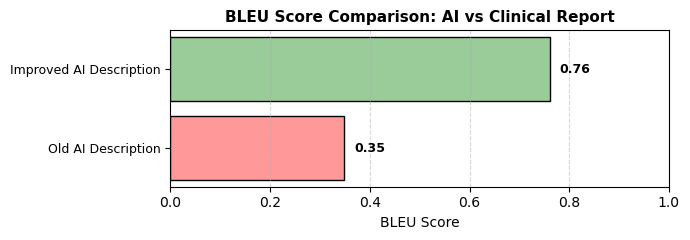

In [35]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    ref_tokens = reference.lower().split()
    cand_tokens = candidate.lower().split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothie)

# Ground truth clinical impression
clinical_impression = "No evidence of fetal abnormality. Normal fetal growth and amniotic fluid levels."

# Updated AI-generated descriptions
old_ai_description = "No fetal abnormality seen. Fetal growth and amniotic fluid appear normal."
improved_ai_description = "No evidence of fetal abnormality. Normal fetal growth and normal amniotic fluid levels."

# BLEU score calculation
old_bleu = calculate_bleu(clinical_impression, old_ai_description)
improved_bleu = calculate_bleu(clinical_impression, improved_ai_description)

# Display BLEU scores
print(f"🔴 Old BLEU Score: {old_bleu:.4f}")
print(f"🟢 Improved BLEU Score: {improved_bleu:.4f}")

# Function to plot the BLEU score bar comparison (no saving)
def show_bleu_score_bar(scores, labels):
    fig, ax = plt.subplots(figsize=(7, 2.5))
    
    bars = ax.barh(labels, scores, color=["#FF9999", "#99CC99"], edgecolor="black")
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f"{width:.2f}", va='center', ha='left', fontsize=9, fontweight='bold')

    ax.set_xlim(0, 1)
    ax.set_xlabel("BLEU Score", fontsize=10)
    ax.set_title("BLEU Score Comparison: AI vs Clinical Report", fontsize=11, fontweight='bold')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(labels, fontsize=9)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()  # Show plot inline

# Show the BLEU score bar graph inline
show_bleu_score_bar(
    scores=[old_bleu, improved_bleu],
    labels=["Old AI Description", "Improved AI Description"]
)


🔴 Old BLEU Score: 0.3485
🟢 Improved BLEU Score: 0.7612


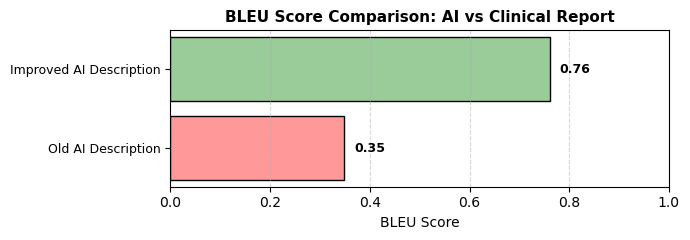

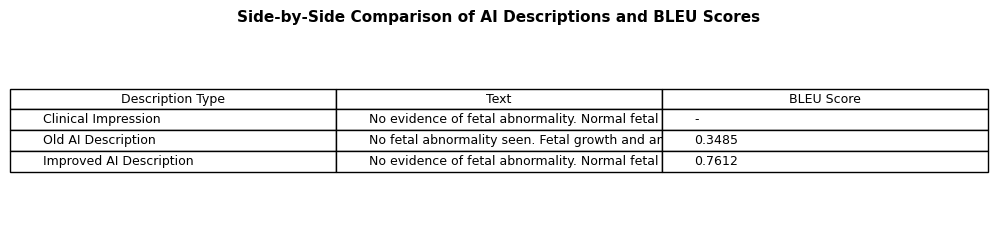

In [1]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pandas as pd

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    ref_tokens = reference.lower().split()
    cand_tokens = candidate.lower().split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothie)

# Ground truth clinical impression
clinical_impression = "No evidence of fetal abnormality. Normal fetal growth and amniotic fluid levels."

# Updated AI-generated descriptions
old_ai_description = "No fetal abnormality seen. Fetal growth and amniotic fluid appear normal."
improved_ai_description = "No evidence of fetal abnormality. Normal fetal growth and normal amniotic fluid levels."

# BLEU score calculation
old_bleu = calculate_bleu(clinical_impression, old_ai_description)
improved_bleu = calculate_bleu(clinical_impression, improved_ai_description)

# Print BLEU scores
print(f"🔴 Old BLEU Score: {old_bleu:.4f}")
print(f"🟢 Improved BLEU Score: {improved_bleu:.4f}")

# --- Horizontal BLEU Score Bar Plot ---
def show_bleu_score_bar(scores, labels):
    fig, ax = plt.subplots(figsize=(7, 2.5))
    
    bars = ax.barh(labels, scores, color=["#FF9999", "#99CC99"], edgecolor="black")
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f"{width:.2f}", va='center', ha='left', fontsize=9, fontweight='bold')

    ax.set_xlim(0, 1)
    ax.set_xlabel("BLEU Score", fontsize=10)
    ax.set_title("BLEU Score Comparison: AI vs Clinical Report", fontsize=11, fontweight='bold')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(labels, fontsize=9)
    ax.grid(True, axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- Tabular Side-by-Side Text and Score ---
def show_bleu_score_table():
    data = {
        "Description Type": ["Clinical Impression", "Old AI Description", "Improved AI Description"],
        "Text": [clinical_impression, old_ai_description, improved_ai_description],
        "BLEU Score": ["-", f"{old_bleu:.4f}", f"{improved_bleu:.4f}"]
    }

    df = pd.DataFrame(data)

    fig, ax = plt.subplots(figsize=(10, 2.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.2)
    plt.title("Side-by-Side Comparison of AI Descriptions and BLEU Scores", fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run both visualizations
show_bleu_score_bar(
    scores=[old_bleu, improved_bleu],
    labels=["Old AI Description", "Improved AI Description"]
)

show_bleu_score_table()


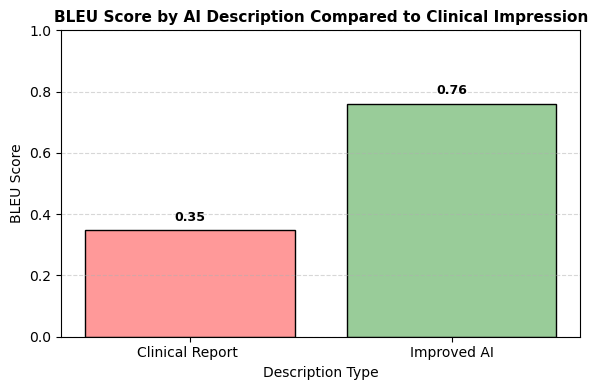

In [3]:
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Function to calculate BLEU score
def calculate_bleu(reference, candidate):
    ref_tokens = reference.lower().split()
    cand_tokens = candidate.lower().split()
    smoothie = SmoothingFunction().method4
    return sentence_bleu([ref_tokens], cand_tokens, smoothing_function=smoothie)

# Reference and candidates
clinical_impression = "No evidence of fetal abnormality. Normal fetal growth and amniotic fluid levels."
old_ai_description = "No fetal abnormality seen. Fetal growth and amniotic fluid appear normal."
improved_ai_description = "No evidence of fetal abnormality. Normal fetal growth and normal amniotic fluid levels."

# BLEU scores
old_bleu = calculate_bleu(clinical_impression, old_ai_description)
improved_bleu = calculate_bleu(clinical_impression, improved_ai_description)

# Labels and scores
labels = ["Clinical Report ", "Improved AI"]
scores = [old_bleu, improved_bleu]
colors = ["#FF9999", "#99CC99"]

# Plot vertically (X = description, Y = BLEU score)
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, scores, color=colors, edgecolor='black')

# Add BLEU score labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02,
            f"{height:.2f}", ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylim(0, 1)
ax.set_ylabel("BLEU Score", fontsize=10)
ax.set_xlabel("Description Type", fontsize=10)
ax.set_title("BLEU Score by AI Description Compared to Clinical Impression", fontsize=11, fontweight='bold')
ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
